In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
import os

In [3]:
# 全局配置plot参数
plt.rcParams['font.sans-serif'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (4.0, 4.0)
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
plt.rcParams['animation.html'] = 'jshtml'
plt.rcParams['axes.labelsize'] = 16

dataset_dir = '/home/lidong/Datasets/'

[Dataset](https://pan.baidu.com/s/1axooVu-QAV6uc-sl44AEwg) 提取码: vqk8

In [4]:
def load_data_from_file(file):
    result = []
    with open(file) as fp:
        for line in fp:
            item = line.rstrip('\n').split(',')
            result.append(list(map(np.float32, item)))
    return result 

def gen_random_value(rnd):
    lo = -0.01
    hi = 0.01
    return (hi - lo) * rnd.random() + lo

In [5]:
train_data = load_data_from_file(os.path.join(dataset_dir, 'ML/irisTrainData.txt'))
test_data = load_data_from_file(os.path.join(dataset_dir, 'ML/irisTestData.txt'))
train_data[0]

[5.1, 3.5, 1.4, 0.2, 1.0, 0.0, 0.0]

In [6]:
class NeuralNetwork(object):
    @staticmethod
    def tanh(hs):
        if hs < -20.0:
            return -1.0
        elif hs > 20.0:
            return 1.0
        else:
            return math.tanh(hs)

    @staticmethod
    def softmax(os):
        result = np.zeros(shape=[len(os)], dtype=np.float32)
        m = max(os)
        divisor = 0.0
        for k in range(len(os)):
          divisor += math.exp(os[k] - m)
        for k in range(len(result)):
          result[k] =  math.exp(os[k] - m) / divisor
        return result
    
    def __init__(self, ni, nh, no):
        self.ni = ni
        self.nh = nh
        self.no = no
        
        self.i_nodes = np.zeros(shape=[self.ni], dtype=np.float32)
        self.h_nodes = np.zeros(shape=[self.nh], dtype=np.float32)
        self.o_nodes = np.zeros(shape=[self.no], dtype=np.float32)
        
        self.ih_weigths = np.zeros(shape=[self.ni, self.nh], dtype=np.float32) # ni * nh
        self.ho_weigths = np.zeros(shape=[self.nh, self.no], dtype=np.float32) # nh * no
        
        self.h_biases = np.zeros(shape=[self.nh], dtype=np.float32) # nh
        self.o_biases = np.zeros(shape=[self.no], dtype=np.float32) # no
        
        # init weight value
        self.rnd = random.Random(0)
        for i in range(self.ni):
            for j in range(self.nh):
                self.ih_weigths[i, j] = gen_random_value(self.rnd)
        
        for j in range(self.nh):
            for k in range(self.no):
                self.ho_weigths[j, k] = gen_random_value(self.rnd)
                
        for j in range(self.nh):
            self.h_biases[j] = gen_random_value(self.rnd)
            
        for k in range(self.no):
            self.o_biases[k] = gen_random_value(self.rnd)
            
    def calculate_nodes_result(self, xs):
        # input nodes
        for i in range(self.ni):
            self.i_nodes[i] = xs[i]
            
        # hiden nodes
        for j in range(self.nh):
            hsums = 0.0
            for i in range(self.ni):
                hsums += self.i_nodes[i] * self.ih_weigths[i, j]
            hsums += self.h_biases[j]
            self.h_nodes[j] = self.tanh(hsums)
            
        # output nodes
        osums = np.zeros(shape=[self.no], dtype=np.float32)
        for k in range(self.no):
            for j in range(self.nh):
                osums[k] += self.h_nodes[j] * self.ho_weigths[j, k]
            osums[k] += self.o_biases[k]
        self.o_nodes = self.softmax(osums)
        return self.o_nodes
    
    def parse_input_target_values(self, data):
        xvalues = np.zeros(shape=[self.ni], dtype=np.float32)
        tvalues = np.zeros(shape=[self.no], dtype=np.float32)
        for i in range(self.ni):
            xvalues[i] = data[i]
        for k in range(self.no):
            tvalues[k] = data[self.ni + k]
        return xvalues, tvalues

    def train(self, data, lrate, epochs, loss_method='mcee'):
        # init hiden layer gradient weigths and bias
        ih_grads = np.zeros(shape=[self.ni, self.nh], dtype=np.float32)
        hb_grads = np.zeros(shape=[self.nh], dtype=np.float32)
        
        # init output layer gradient of weigths  and biases
        ho_grads = np.zeros(shape=[self.nh, self.no], dtype=np.float32)
        ob_grads = np.zeros(shape=[self.no], dtype=np.float32)
        
        # init hiden and ouput layer middle calculate signals
        h_signals = np.zeros(shape=[self.nh], dtype=np.float32)
        o_signals = np.zeros(shape=[self.no], dtype=np.float32)
        
        # init input values and target values
        # xvalues = np.zeros(shape=[self.ni], dtype=np.float32)
        # tvalues = np.zeros(shape=[self.no], dtype=np.float32)
        
        errs = []
        length = len(data)
        indices = np.arange(length)
        for epoch in range(1, epochs+1):
            # self.rnd.shuffle(indices)
            for ri in range(length):
                idx = indices[ri]
                
                # eval xvalues and tvalues
                xvalues, tvalues = self.parse_input_target_values(data[idx])
                
                # calculate the input, hiden, output nodes
                self.calculate_nodes_result(xvalues)
                
                # 1. compute the o_signals
                if loss_method == 'mse':
                    for k in range(self.no):
                        o_signals[k] = (tvalues[k] - self.o_nodes[k]) * (1 - self.o_nodes[k]) * self.o_nodes[k]
                else:
                    for k in range(self.no):
                        o_signals[k] = (tvalues[k] - self.o_nodes[k]) * 1.0
                
                # 2. compute the ho_grads and ob_grads
                for k in range(self.no):
                    for j in range(self.nh):
                        ho_grads[j, k] = o_signals[k] * self.h_nodes[j]
                    ob_grads[k] = o_signals[k] * 1.0
                
                # 3. compute the h_signals
                for j in range(self.nh):
                    sum = 0.0
                    for k in range(self.no):
                        sum += o_signals[k] * self.ho_weigths[j, k]
                    h_signals[j] = (1 - self.h_nodes[j]) * (1 + self.h_nodes[j]) * sum
                    
                # 4. compute the ih_grads and hb_grads
                for j in range(self.nh):
                    for i in range(self.ni):
                        ih_grads[i, j] = h_signals[j] * self.i_nodes[i]
                    hb_grads[j] = h_signals[j] * 1.0
                    
                # 5. update ih_weigths and h_biases
                for j in range(self.nh):
                    for i in range(self.ni):
                        self.ih_weigths[i, j] += lrate * ih_grads[i, j]
                    self.h_biases[j] += lrate * hb_grads[j]
                    
                # 6. update ho_weigths and o_biases
                for k in range(self.no):
                    for j in range(self.nh):
                        self.ho_weigths[j, k] += lrate * ho_grads[j, k]
                    self.o_biases[k] += lrate * ob_grads[k]
            # end sample       
            if loss_method == 'mse':
                err = self.mse(data)
            else:
                err = self.mcee(data)
            if epoch % 10 == 0:
                print('epoch[%d]\t%s err[%0.4f]' % (epoch, loss_method, err))
            errs.append(err)
        # end epoch
        return errs 
                    
    def mse(self, data):
        # mean squared error
        length = len(data)
        sum_err = 0.0
        for i in range(length):
            xvalues, tvalues = self.parse_input_target_values(data[i])
            yvalues = self.calculate_nodes_result(xvalues)
            for k in range(self.no):
                err = tvalues[k] - yvalues[k]
                sum_err += err * err
        return sum_err / length
            
    
    def mcee(self, data):
        # mean cross entropy error
        length = len(data)
        sum_err = 0.0
        for i in range(length):
            xvalues, tvalues = self.parse_input_target_values(data[i])
            yvalues = self.calculate_nodes_result(xvalues)
            # 1.0: tvalues is one-hot
            sum_err += math.log(yvalues[np.argmax(tvalues)])
        return -1.0 * sum_err / length
                    
    def accuracy(self, data):
        num_wrong = 0; num_correct = 0
        length = len(data)
        for i in range(length):
            xvalues, tvalues = self.parse_input_target_values(data[i])
            yvalues = self.calculate_nodes_result(xvalues)
            tval = tvalues[np.argmax(yvalues)]
            if abs(tval - 1.0) < 0.0001:
                num_correct += 1
            else:
                num_wrong += 1
        return (num_correct * 1.0) / length

In [7]:
nn = NeuralNetwork(4, 5, 3)
mcess_data = nn.train(train_data, 0.005, 100, 'mcee')
print('train data accuracy: %.3f' % nn.accuracy(train_data))
print('test  data accuracy: %.3f' % nn.accuracy(test_data))

epoch[10]	mcee err[1.1016]
epoch[20]	mcee err[1.1917]
epoch[30]	mcee err[0.8595]
epoch[40]	mcee err[0.6127]
epoch[50]	mcee err[0.5086]
epoch[60]	mcee err[0.4309]
epoch[70]	mcee err[0.3752]
epoch[80]	mcee err[0.3363]
epoch[90]	mcee err[0.3090]
epoch[100]	mcee err[0.2894]
train data accuracy: 0.883
test  data accuracy: 0.900


In [8]:
nn = NeuralNetwork(4, 5, 3)
mse_data = nn.train(train_data, 0.005, 100, 'mse')
print('train data accuracy: %.3f' % nn.accuracy(train_data))
print('test  data accuracy: %.3f' % nn.accuracy(test_data))

epoch[10]	mse err[0.6651]
epoch[20]	mse err[0.6516]
epoch[30]	mse err[0.5892]
epoch[40]	mse err[0.4527]
epoch[50]	mse err[0.3656]
epoch[60]	mse err[0.3274]
epoch[70]	mse err[0.3041]
epoch[80]	mse err[0.2854]
epoch[90]	mse err[0.2689]
epoch[100]	mse err[0.2542]
train data accuracy: 0.808
test  data accuracy: 0.867


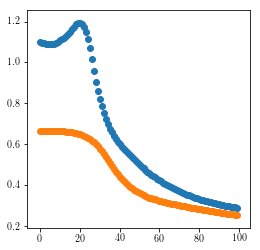

In [9]:
xs = [i for i in range(len(mcess_data))]
plt.scatter(xs, mcess_data)
plt.scatter(xs, mse_data)